
# Анализ дорожно-транспортных проишествий по Кировской области 

В этой работе проводится анализ данных «Карты ДТП» — некоммерческого проекта, посвящённого проблеме дорожно-транспортных происшествий в России.

Заказчика интересует, с чем может быть связана аварийность на дорогах.

- Автор: Юрий Кузнецов

- Дата: 05.03.2025


## Что нужно сделать
Выполнить предобработку для удобства работы с данными: выбрать оптимальные названия столбцов и типы данных. Вам также понадобится дать ответы на вопросы заказчика.

### Вопросы заказчика

1. Как распределено количество участников ДТП и почему? Встречаются ли аномальные значения или выбросы? Если да, то с чем они могут быть связаны? Для числа участников найти наиболее типичное значение. Проверить распределения и других столбцов.

2. Между какими столбцами в датасете `Kirovskaya_oblast.csv` высокая корреляция. Проверить своё предположение.  

3. Как связаны категории аварий и погодные условия?

4. Построить процентную разбивку аварий по видам освещённости с усетом пола участника и сделать расчёты для мужчин и женщин отдельно.

5. Исследовать, чем отличаются аварии без пострадавших от тех, в которых был один пострадавший или более.

6. Сделать общий вывод о связи аварийности с другими факторами, а также рекомендации.

## Описание данных

Датасет `Kirovskaya_oblast.csv` содержит информацию о ДТП в Кировской области:

* `geometry.coordinates` — координаты ДТП;

* `id` — идентификатор ДТП;

* `properties.tags` — тег происшествия;

* `properties.light` — освещённость;

* `properties.point.lat` — широта;

* `properties.point.long` — долгота;

* `properties.nearby` — ближайшие объекты;

* `properties.region` — регион;

* `properties.scheme` — схема ДТП;

* `properties.address` — ближайший адрес;

* `properties.weather` — погода;

* `properties.category` — категория ДТП;

* `properties.datetime` — дата и время ДТП;

* `properties.injured_count` — число пострадавших;

* `properties.parent_region` — область;

* `properties.road_conditions` — состояние покрытия;

* `properties.participants_count` — число участников;

* `properties.participant_categories` — категории участников.

`Kirovskaya_oblast_participiants.csv` хранит сведения об участниках:

* `role` — роль;

* `gender` — пол;

* `violations` — какие правила дорожного движения были нарушены конкретным участником;

* `health_status` — состояние здоровья после ДТП;

* `years_of_driving_experience` — число лет опыта;

* `id` — идентификатор ДТП.


# Кейс спринта


В этом кейсе вы будете работать с данными «Карты ДТП» — некоммерческого проекта, посвящённого проблеме дорожно-транспортных происшествий в России. Вы могли знакомиться с этим проектом в Песочнице прошлого спринта.

Заказчик предлагает продолжить исследование данных и изучить взаимосвязи. Особенно заказчика интересует, с чем может быть связана аварийность на дорогах.

## Что нужно сделать
Выполнить предобработку для удобства работы с данными: выбрать оптимальные названия столбцов и типы данных. Вам также понадобится дать ответы на вопросы заказчика.

Если вы не работали с прошлой Песочницей, то всё равно можете выполнить этот проект. Для удобства советуем изменить названия столбцов датафрейма, используя код ниже:

```
import pandas as pd

df = pd.read_csv('путь до папки с файлами/Kirovskaya_oblast.csv')
df.columns = [c.replace('properties.', '') for c in df.columns]

```


### Вопросы заказчика

1. Как распределено количество участников ДТП и почему? Встречаются ли аномальные значения или выбросы? Если да, то с чем они могут быть связаны? Для числа участников найдите наиболее типичное значение. По желанию можете проверить распределения и других столбцов.

2. Предположите, между какими столбцами в датасете `Kirovskaya_oblast.csv` высокая корреляция. Проверьте своё предположение.  

3. Как связаны категории аварий и погодные условия?

4. Постройте процентную разбивку аварий по видам освещённости. При этом учитывайте пол участника и сделайте расчёты для мужчин и женщин отдельно.

5. Исследуйте, чем отличаются аварии без пострадавших от тех, в которых был один пострадавший или более.

6. Сделайте общий вывод о связи аварийности с другими факторами. Какие рекомендации вы можете дать заказчику?

## Описание данных

Датасет `Kirovskaya_oblast.csv` содержит информацию о ДТП в Кировской области:

* `geometry.coordinates` — координаты ДТП;

* `id` — идентификатор ДТП;

* `properties.tags` — тег происшествия;

* `properties.light` — освещённость;

* `properties.point.lat` — широта;

* `properties.point.long` — долгота;

* `properties.nearby` — ближайшие объекты;

* `properties.region` — регион;

* `properties.scheme` — схема ДТП;

* `properties.address` — ближайший адрес;

* `properties.weather` — погода;

* `properties.category` — категория ДТП;

* `properties.datetime` — дата и время ДТП;

* `properties.injured_count` — число пострадавших;

* `properties.parent_region` — область;

* `properties.road_conditions` — состояние покрытия;

* `properties.participants_count` — число участников;

* `properties.participant_categories` — категории участников.

`Kirovskaya_oblast_participiants.csv` хранит сведения об участниках:

* `role` — роль;

* `gender` — пол;

* `violations` — какие правила дорожного движения были нарушены конкретным участником;

* `health_status` — состояние здоровья после ДТП;

* `years_of_driving_experience` — число лет опыта;

* `id` — идентификатор ДТП.

### Подключение библиотек и загрузка данных

In [1]:
 !pip install phik 


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from phik import phik_matrix

### Загрузка датасета с информацией о ДТП по Кировской области

In [3]:
df_dtp_info_k = pd.read_csv('https://code.s3.yandex.net/datasets/Kirovskaya_oblast.csv')

In [4]:
df_dtp_info_k.head()

,geometry.coordinates,id,properties.tags,properties.light,properties.point.lat,properties.point.long,properties.nearby,properties.region,properties.scheme,properties.address,properties.weather,properties.category,properties.datetime,properties.injured_count,properties.parent_region,properties.road_conditions,properties.participants_count,properties.participant_categories
0,"[47.875603, 57.24379]",1983180,Дорожно-транспортные происшествия,Светлое время суток,57.243790,47.875603,[],Яранский район,600.0,Р-176 Вятка Чебоксары - Йошкар-Ола - Киров - С...,['Дождь'],Опрокидывание,2017-07-01 18:00:00,1,Кировская область,['Мокрое'],3,['Все участники']
1,"[47.87903, 57.304807]",2889433,Дорожно-транспортные происшествия,Светлое время суток,57.304807,47.879030,"['Административные здания', 'Нерегулируемый пе...",Яранский район,710.0,"г Яранск, ул Кирова, 10",['Ясно'],Наезд на пешехода,2023-09-12 17:10:00,1,Кировская область,"['Сухое', 'Отсутствие, плохая различимость гор...",2,"['Все участники', 'Пешеходы']"
2,"[47.840781, 57.297156]",2591208,Дорожно-транспортные происшествия,Сумерки,57.297156,47.840781,"['Жилые дома индивидуальной застройки', 'Нерег...",Яранский район,NaN,"г Яранск, ул Чапаева, 80",['Пасмурно'],Съезд с дороги,2021-07-02 21:25:00,1,Кировская область,['Мокрое'],1,['Все участники']
3,"[47.834365, 57.244775]",2577639,Дорожно-транспортные происшествия,Светлое время суток,57.244775,47.834365,['Жилые дома индивидуальной застройки'],Яранский район,200.0,"м Знаменка, ул Кирова, 15",['Пасмурно'],Столкновение,2021-05-31 18:55:00,1,Кировская область,['Сухое'],2,"['Все участники', 'Мотоциклисты']"
4,"[47.968197, 57.357738]",1981026,Дорожно-транспортные происшествия,Светлое время суток,57.357738,47.968197,['Нерегулируемый перекрёсток неравнозначных ул...,Яранский район,NaN,"с/п Никольское, Киров-Советск- Яранск - подъез...",['Ясно'],Опрокидывание,2018-05-16 16:25:00,2,Кировская область,"['Сухое', 'Отсутствие, плохая различимость гор...",2,['Все участники']


#### Оптимизация назаваний столбцов 


In [5]:
df_dtp_info_k.columns = [c.replace('properties.', '') for c in df_dtp_info_k.columns]
df_dtp_info_k.columns = [c.replace('.', '_') for c in df_dtp_info_k.columns]

In [6]:
df_dtp_info_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14517 entries, 0 to 14516
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   geometry_coordinates    14517 non-null  object 
 1   id                      14517 non-null  int64  
 2   tags                    14517 non-null  object 
 3   light                   14517 non-null  object 
 4   point_lat               14485 non-null  float64
 5   point_long              14485 non-null  float64
 6   nearby                  14517 non-null  object 
 7   region                  14517 non-null  object 
 8   scheme                  13380 non-null  float64
 9   address                 13843 non-null  object 
 10  weather                 14517 non-null  object 
 11  category                14517 non-null  object 
 12  datetime                14517 non-null  object 
 13  injured_count           14517 non-null  int64  
 14  parent_region           14517 non-null

df_dtp_info_k содержит 14517 строк в 18 столбцах

#### Проверим пропуски в датасете df_dtp_info_k с информацией о ДТП

In [7]:
missing = (pd.DataFrame({'Кол-во пропусков': df_dtp_info_k.isnull().sum(), 'Процент пропусков': round(df_dtp_info_k.isnull().mean().round(5), 3)*100}).sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))
missing

,Кол-во пропусков,Процент пропусков
scheme,1137,7.800000
address,674,4.600000
point_lat,32,0.200000
point_long,32,0.200000
category,0,0.000000
participants_count,0,0.000000
road_conditions,0,0.000000
parent_region,0,0.000000
injured_count,0,0.000000
datetime,0,0.000000


In [8]:
df_dtp_info_k[['scheme', 'address']] = df_dtp_info_k[['scheme', 'address']].fillna('нет данных')

Пропуски содержатся в столбцах scheme (7,8%), address (4,6%), заполним их значением 'нет данных'. point_lat (0,2%), point_long (0,2%), которые не понадобятся нам для данного исследования. Удалять или заполнять их нецелесообразно 

#### Обработка дубликатов в датасете df_dtp_info_k

In [9]:
df_dtp_info_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14517 entries, 0 to 14516
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   geometry_coordinates    14517 non-null  object 
 1   id                      14517 non-null  int64  
 2   tags                    14517 non-null  object 
 3   light                   14517 non-null  object 
 4   point_lat               14485 non-null  float64
 5   point_long              14485 non-null  float64
 6   nearby                  14517 non-null  object 
 7   region                  14517 non-null  object 
 8   scheme                  14517 non-null  object 
 9   address                 14517 non-null  object 
 10  weather                 14517 non-null  object 
 11  category                14517 non-null  object 
 12  datetime                14517 non-null  object 
 13  injured_count           14517 non-null  int64  
 14  parent_region           14517 non-null

In [10]:
# Приведем данные текстовых столбцах df_dtp_info
for column in ['tags', 'light', 'region', 'address', 'weather','category', 'parent_region', 'road_conditions', 'participant_categories']:
    df_dtp_info_k[column]=df_dtp_info_k[column].apply(lambda x:x.lower().strip())

Проверим наличие явных дубликатов

In [11]:
df_dtp_info_k.duplicated().sum()

0

Явных дубликатов нет

In [12]:
df_dtp_info_k['id'].duplicated().sum()

0

Все id уникальны, то есть неявных дубликатов тоже нет

#### Проверим и оптимизируем типы данных датасета df_dtp_info_k

In [13]:
df_dtp_info_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14517 entries, 0 to 14516
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   geometry_coordinates    14517 non-null  object 
 1   id                      14517 non-null  int64  
 2   tags                    14517 non-null  object 
 3   light                   14517 non-null  object 
 4   point_lat               14485 non-null  float64
 5   point_long              14485 non-null  float64
 6   nearby                  14517 non-null  object 
 7   region                  14517 non-null  object 
 8   scheme                  14517 non-null  object 
 9   address                 14517 non-null  object 
 10  weather                 14517 non-null  object 
 11  category                14517 non-null  object 
 12  datetime                14517 non-null  object 
 13  injured_count           14517 non-null  int64  
 14  parent_region           14517 non-null

id следует перевести в тип object

datetime привести к datetime

injured_count и participants_count следует понизить разрядность

In [14]:
df_dtp_info_k['id']=df_dtp_info_k['id'].astype('object')

In [15]:
df_dtp_info_k['datetime']=df_dtp_info_k['datetime'].astype('datetime64[ns]')

In [16]:
df_dtp_info_k['injured_count']=pd.to_numeric(df_dtp_info_k['injured_count'], downcast='integer')
df_dtp_info_k['participants_count']=pd.to_numeric(df_dtp_info_k['participants_count'], downcast='integer')

In [17]:
#for column in ['tags', 'light', 'region','weather','category', 'parent_region', 'road_conditions', 'participant_categories']:
#    df_dtp_info_k[column] = df_dtp_info_k[column].astype('category')

In [18]:
df_dtp_info_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14517 entries, 0 to 14516
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   geometry_coordinates    14517 non-null  object        
 1   id                      14517 non-null  object        
 2   tags                    14517 non-null  object        
 3   light                   14517 non-null  object        
 4   point_lat               14485 non-null  float64       
 5   point_long              14485 non-null  float64       
 6   nearby                  14517 non-null  object        
 7   region                  14517 non-null  object        
 8   scheme                  14517 non-null  object        
 9   address                 14517 non-null  object        
 10  weather                 14517 non-null  object        
 11  category                14517 non-null  object        
 12  datetime                14517 non-null  dateti

### Загрузка датасета с информацией об участниках ДТП по Кировской области


In [19]:
df_dtp_participants_k = pd.read_csv('https://code.s3.yandex.net/datasets/Kirovskaya_oblast_participiants.csv')

In [20]:
df_dtp_participants_k.head()

,role,gender,violations,health_status,years_of_driving_experience,id
0,Водитель,Мужской,['Несоответствие скорости конкретным условиям ...,"Раненый, находящийся (находившийся) на амбулат...",26.0,1983180
1,Водитель,Мужской,[],Не пострадал,34.0,2889433
2,Пассажир,Мужской,[],"Раненый, находящийся (находившийся) на амбула...",NaN,2591208
3,Пассажир,Мужской,[],"Раненый, находящийся (находившийся) на амбула...",NaN,2591208
4,Водитель,Мужской,[],Не пострадал,27.0,2577639


In [21]:
df_dtp_participants_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31235 entries, 0 to 31234
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   role                         31235 non-null  object 
 1   gender                       30387 non-null  object 
 2   violations                   31235 non-null  object 
 3   health_status                31135 non-null  object 
 4   years_of_driving_experience  16909 non-null  float64
 5   id                           31235 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ MB


df_dtp_participants_k 31235 строк в 6 столбцах содержит информацию об участниках в Кировской области

#### Проверим пропуски в датасете df_dtp_participants_k с информацией об участниках ДТП

In [22]:
missing_p = (pd.DataFrame({'Кол-во пропусков': df_dtp_participants_k.isnull().sum(), 'Процент пропусков': round(df_dtp_participants_k.isnull().mean().round(5), 3)*100}).sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))
missing_p

,Кол-во пропусков,Процент пропусков
years_of_driving_experience,14326,45.900000
gender,848,2.700000
health_status,100,0.300000
role,0,0.000000
violations,0,0.000000
id,0,0.000000


39,4 % пропусков в поле years_of_driving_experience, лет вождения, что модет говорить о водителях с отсутствующим стажем вождения. Предполагаем заменить на значение 0.
Пол водителя не указан в 2.2 % данных, что является случайным. Предполагается заменить на индикатор "нет данных"
Состояние здоровья не указано в 0.2 %. Что может означать что здоровье осталось в норме после дтп. Однако это лишь предположение. Предполагается заменить на моду


In [23]:
#df_dtp_participants['years_of_driving_experience']=df_dtp_participants['years_of_driving_experience'].fillna(0)
#df_dtp_participants_k['gender']=df_dtp_participants_k['gender'].fillna('нет данных')
df_dtp_participants_k['health_status']=df_dtp_participants_k['health_status'].fillna('Не пострадал')

In [24]:
df_dtp_participants_k['health_status'].mode()

0    Не пострадал
Name: health_status, dtype: object

In [25]:
missing_p = (pd.DataFrame({'Кол-во пропусков': df_dtp_participants_k.isnull().sum(), 'Процент пропусков': round(df_dtp_participants_k.isnull().mean().round(5), 3)*100}).sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))
missing_p

,Кол-во пропусков,Процент пропусков
years_of_driving_experience,14326,45.900000
gender,848,2.700000
role,0,0.000000
violations,0,0.000000
health_status,0,0.000000
id,0,0.000000


Пропуски в столбце years_of_driving_experience оставим как есть. Они по видимому неслучайны, но об их наличии мы ничего не можем сказать на основе имеющихся данных

#### Проверим дубликаты в датасете df_dtp_participants

In [26]:
# Приведем данные текстовых столбцах df_dtp_info
for column in ['role', 'violations', 'health_status']:
    df_dtp_participants_k[column]=df_dtp_participants_k[column].apply(lambda x:x.lower().strip())

In [27]:
df_dtp_participants_k.duplicated().sum()

9727

In [28]:
round(df_dtp_participants_k.duplicated().sum()/df_dtp_participants_k.shape[0], 3)*100

31.1

Обнаружено наличие явных дубликатов 31,1%. Удалим их

In [29]:
df_dtp_participants_k = df_dtp_participants_k.drop_duplicates()


In [30]:
df_dtp_participants_k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21508 entries, 0 to 31232
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   role                         21508 non-null  object 
 1   gender                       20951 non-null  object 
 2   violations                   21508 non-null  object 
 3   health_status                21508 non-null  object 
 4   years_of_driving_experience  11144 non-null  float64
 5   id                           21508 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.1+ MB


Поищем неявные

In [31]:
df_dtp_participants_k[['role', 'gender', 'violations', 'health_status', 'id']].duplicated().sum()

0

In [32]:
df_dtp_participants_k['id'].duplicated().sum()

8168

В данном датасете значение id может повторяться, так как в одном ДТП может быть более одного участника

Неявных дубликатов не обнаружено

#### Проверка и оптимизация типов данных df_dtp_participants_k

In [33]:
df_dtp_participants_k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21508 entries, 0 to 31232
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   role                         21508 non-null  object 
 1   gender                       20951 non-null  object 
 2   violations                   21508 non-null  object 
 3   health_status                21508 non-null  object 
 4   years_of_driving_experience  11144 non-null  float64
 5   id                           21508 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.1+ MB


тип данных years_of_driving_experience следует привести к целочисленному типу

In [34]:
df_dtp_participants_k['years_of_driving_experience']=df_dtp_participants_k['years_of_driving_experience'].astype('Int64')
df_dtp_participants_k['years_of_driving_experience']=pd.to_numeric(df_dtp_participants_k['years_of_driving_experience'], downcast='integer')

Значения id к типу object

In [35]:
df_dtp_participants_k['id']=df_dtp_participants_k['id'].astype('object')

In [36]:
df_dtp_participants_k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21508 entries, 0 to 31232
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   role                         21508 non-null  object
 1   gender                       20951 non-null  object
 2   violations                   21508 non-null  object
 3   health_status                21508 non-null  object
 4   years_of_driving_experience  11144 non-null  Int8  
 5   id                           21508 non-null  object
dtypes: Int8(1), object(5)
memory usage: 1.0+ MB


### Объединим датасеты df_dtp_info_k и df_dtp_participants_k

In [37]:
df=df_dtp_info_k.merge(df_dtp_participants_k, on='id', how='outer')

In [38]:
df.head()

,geometry_coordinates,id,tags,light,point_lat,point_long,nearby,region,scheme,address,...,injured_count,parent_region,road_conditions,participants_count,participant_categories,role,gender,violations,health_status,years_of_driving_experience
0,"[47.886008, 57.30447]",1979481,дорожно-транспортные происшествия,светлое время суток,57.304470,47.886008,"['Многоквартирные жилые дома', 'Нерегулируемый...",яранский район,740.0,"г яранск, ул кирова, 25",...,1,кировская область,['сухое'],2,"['все участники', 'пешеходы', 'дети']",водитель,Мужской,[],не пострадал,26
1,"[47.886008, 57.30447]",1979481,дорожно-транспортные происшествия,светлое время суток,57.304470,47.886008,"['Многоквартирные жилые дома', 'Нерегулируемый...",яранский район,740.0,"г яранск, ул кирова, 25",...,1,кировская область,['сухое'],2,"['все участники', 'пешеходы', 'дети']",пешеход,Женский,[],"раненый, находящийся (находившийся) на амбула...",<NA>
2,"[50.737665, 57.822582]",1979482,дорожно-транспортные происшествия,светлое время суток,57.822582,50.737665,['Жилые дома индивидуальной застройки'],богородский район,610.0,"пгт богородское, ул советская, 97",...,1,кировская область,['сухое'],2,['все участники'],водитель,Мужской,['нарушение правил расположения тс на проезжей...,не пострадал,<NA>
3,"[50.737665, 57.822582]",1979482,дорожно-транспортные происшествия,светлое время суток,57.822582,50.737665,['Жилые дома индивидуальной застройки'],богородский район,610.0,"пгт богородское, ул советская, 97",...,1,кировская область,['сухое'],2,['все участники'],пешеход,Мужской,[],"раненый, находящийся (находившийся) на амбула...",<NA>
4,"[47.14992, 58.1711]",1979483,дорожно-транспортные происшествия,светлое время суток,58.171100,47.149920,[],шабалинский район,200.0,"кострома - шарья - киров - пермь р-243, 64 км",...,3,кировская область,['мокрое'],5,['все участники'],пассажир,Женский,[],получил телесные повреждения с показанием к ле...,<NA>


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22685 entries, 0 to 22684
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   geometry_coordinates         22685 non-null  object        
 1   id                           22685 non-null  object        
 2   tags                         22685 non-null  object        
 3   light                        22685 non-null  object        
 4   point_lat                    22642 non-null  float64       
 5   point_long                   22642 non-null  float64       
 6   nearby                       22685 non-null  object        
 7   region                       22685 non-null  object        
 8   scheme                       22685 non-null  object        
 9   address                      22685 non-null  object        
 10  weather                      22685 non-null  object        
 11  category                     22685 non-nu

Общий датасет df имеет 22685 строк и 23 столбца, содержит информацию о дорожно-транспортных происшествиях и участниках. Все пропуски и дубликаты обработаны, ти


## Исследование данных

### 1. Как распределено количество участников ДТП и почему? Встречаются ли аномальные значения или выбросы? Если да, то с чем они могут быть связаны? Для числа участников найти наиболее типичное значение. Проверить распределения и других столбцов.

#### Исследуем участников ДТП

In [40]:
df['participants_count'].describe()

count    22685.000000
mean         2.350540
std          0.986921
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         30.000000
Name: participants_count, dtype: float64

Среднее значение числа участников отличается в большую сторону от медианы, следует ожидать правосимметричного распределения

Посмотрим распределение на диаграмме размаха

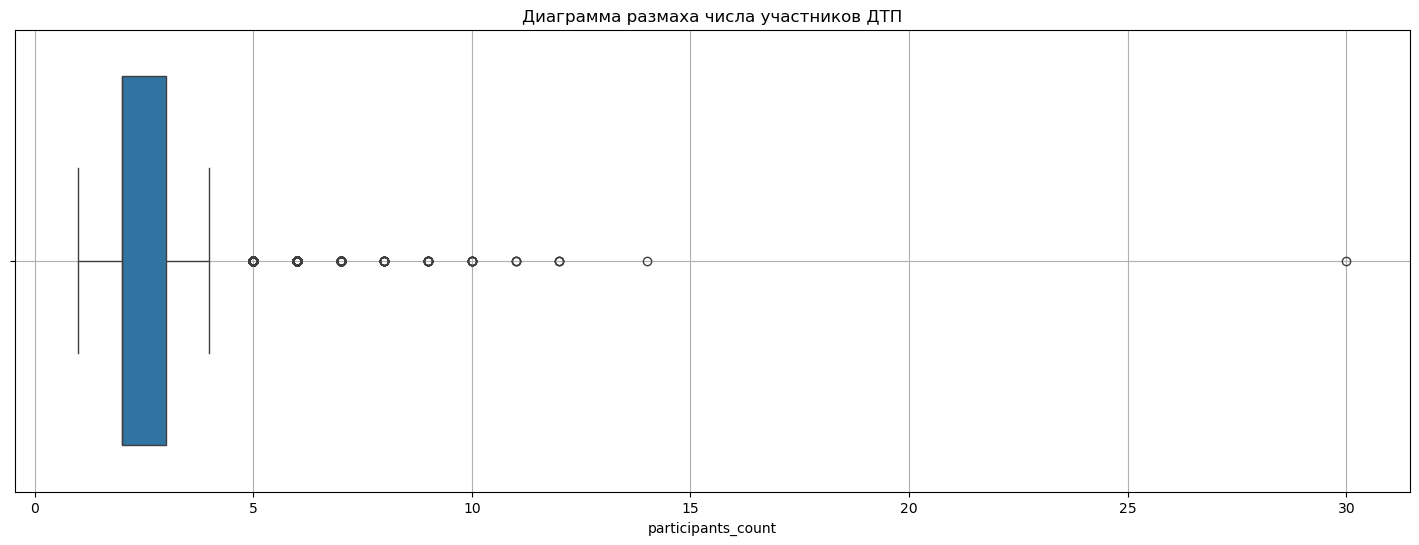

In [41]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df, x='participants_count')

plt.title('Диаграмма размаха числа участников ДТП')
plt.grid()
plt.show()

Действительно имеются выбросы значений, которые могут интерпретироваться редкими случаями ДТП
Значение 30 участников аномально высокое, возможно ошибка ввода данных

Посмотрим информацию по данному ДТП

In [42]:
df[df['participants_count']==30]

,geometry_coordinates,id,tags,light,point_lat,point_long,nearby,region,scheme,address,...,injured_count,parent_region,road_conditions,participants_count,participant_categories,role,gender,violations,health_status,years_of_driving_experience
19123,"[49.611833, 58.585626]",2822118,дорожно-транспортные происшествия,светлое время суток,58.585626,49.611833,"['Выезд с прилегающей территории', 'Крупный то...",киров,930.0,"г киров, ул производственная, 24в",...,30,кировская область,"['сухое', 'отсутствие, плохая различимость гор...",30,['все участники'],водитель,Мужской,['нарушение правил проезда пешеходного переход...,не пострадал,7


Число пострадавших и число участников ДТП одинаковое, не похоже на ошибку ввода данных. Поиск в интернете показал, что такое ДТП действительно случилось с пассажирским автобусом в Кировской области по этому адресу.

Не будем учитывать это значение чтобы определить наиболее типичное значение числа участников ДТП

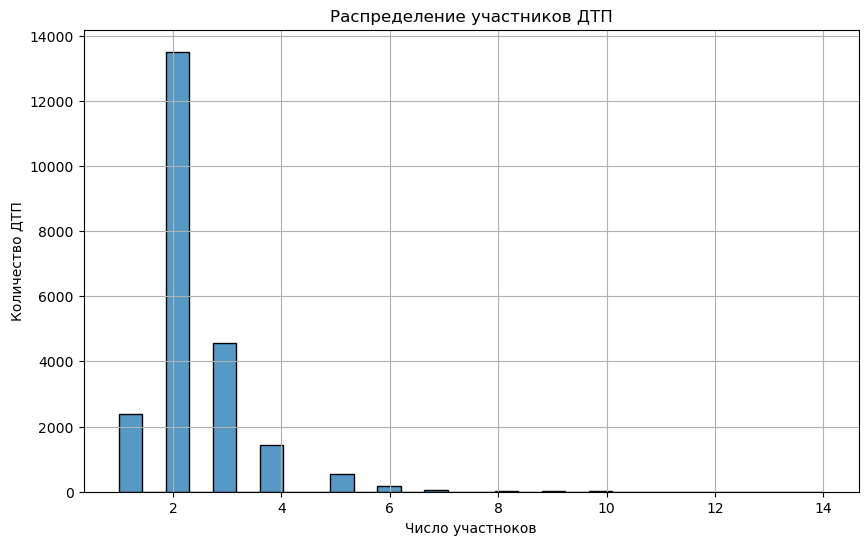

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['participants_count']< 30], x='participants_count', bins=30)

plt.title('Распределение участников ДТП')
plt.ylabel('Количество ДТП')
plt.xlabel('Число участноков')
plt.grid()
plt.show()

- Наиболее типичное число участников ДТП 2.

In [44]:
df_participants = pd.DataFrame({'Число ДТП': df.groupby('participants_count')['id'].nunique(),
                             'Процент': round(df.groupby('participants_count')['id'].nunique()/df.groupby('participants_count')['id'].nunique().sum(), 4)*100
                            }).head(15)

df_participants_sorted = df_participants.sort_values(by='Число ДТП', ascending=False).reset_index()
df_participants_sorted = df_participants_sorted.rename(columns={'participants_count':'Число участников'})
df_participants_sorted['№'] = range(1, len(df_participants_sorted) + 1)
df_participants_sorted = df_participants_sorted.set_index('№')
df_participants_sorted=df_participants_sorted.style.background_gradient(cmap='coolwarm')
df_participants_sorted

,Число участников,Число ДТП,Процент
№,,,
1,2,8611,59.320000
2,3,2929,20.180000
3,1,1533,10.560000
4,4,909,6.260000
5,5,353,2.430000
6,6,109,0.750000
7,7,44,0.300000
8,8,9,0.060000
9,9,9,0.060000


- 59,3 % случаев ДТП происходит с 2 участниками, это вполне логично, учитывая, что как правило в ДТП учавствуют 2 стороны: водитель-водитель или водитель-пешеход.
- 20,2 % с 3 участниками, по-видимому с участием еще и пассажира
- 10,6 с одним в случаях ДТП с одним ТС, например при сьезде с дороги

#### Проанализируем распределение пострадавших в ДТП

In [45]:
df['injured_count'].describe()

count    22685.000000
mean         1.308662
std          0.773866
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         30.000000
Name: injured_count, dtype: float64

Среднее значение также отличается от медианы в большую сторону, что говорит о высоких значения выбросов

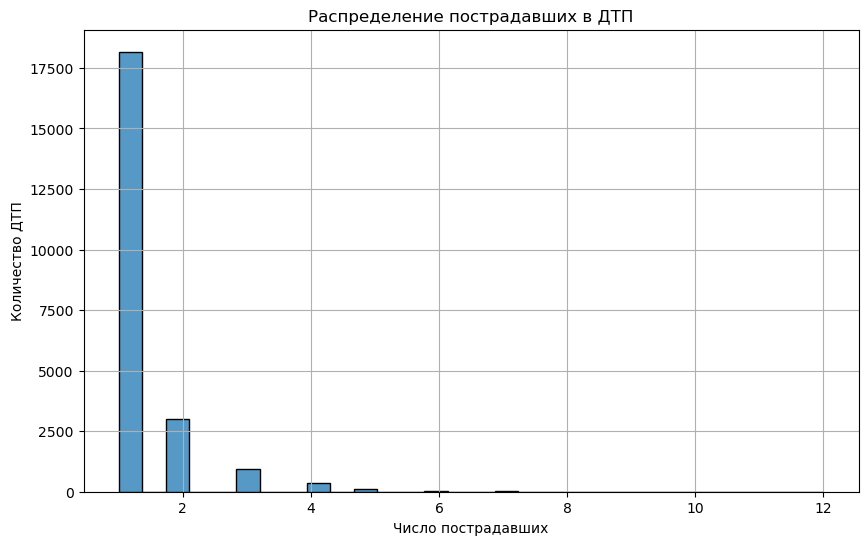

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['injured_count']< 30], x='injured_count', bins=30)

plt.title('Распределение пострадавших в ДТП')
plt.ylabel('Количество ДТП')
plt.xlabel('Число пострадавших')
plt.grid()
plt.show()

In [47]:
df_injured = pd.DataFrame({'Число ДТП': df.groupby('injured_count')['id'].nunique(),
                             'Процент': round(df.groupby('injured_count')['id'].nunique()/df.groupby('injured_count')['id'].nunique().sum(), 4)*100
                            }).head(15)

df_injured_sorted = df_injured.sort_values(by='Число ДТП', ascending=False).reset_index()
df_injured_sorted = df_injured_sorted.rename(columns={'injured_count':'Число пострадавших'})
df_injured_sorted['№'] = range(1, len(df_injured_sorted) + 1)
df_injured_sorted = df_injured_sorted.set_index('№')
df_injured_sorted=df_injured_sorted.style.background_gradient(cmap='coolwarm')
df_injured_sorted

,Число пострадавших,Число ДТП,Процент
№,,,
1,1,11562,79.640000
2,2,1959,13.490000
3,3,616,4.240000
4,4,243,1.670000
5,5,86,0.590000
6,6,29,0.200000
7,7,12,0.080000
8,8,4,0.030000
9,9,2,0.010000


- В 79,6 % случаев ДТП имеется один пострадавший, двое в 13,5 % происшествий, трое в 4,2 %

### 2. Предположение и проверка корреляции между столбцами

Для этого применим рассчет коэффициента корреляции phi k

interval columns not set, guessing: ['years_of_driving_experience', 'injured_count']


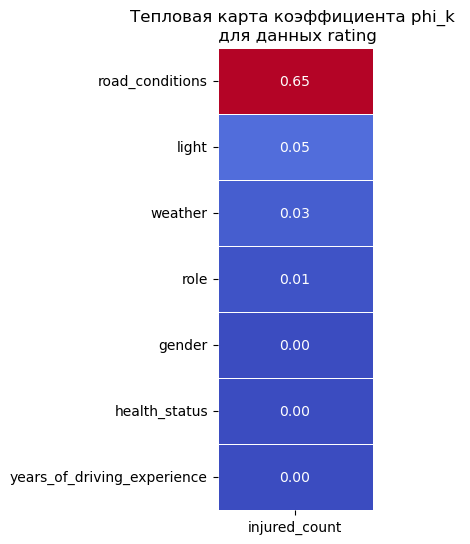

In [48]:
correlation_matrix = df[['light', 'weather', 'road_conditions', 'gender', 'health_status',
                         'years_of_driving_experience', 'role', 'injured_count']].phik_matrix()
plt.figure(figsize=(2, 6))

data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'injured_count'][['injured_count']].sort_values(by='injured_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            linewidths=0.5, 
            cbar=False 
           )
plt.title('Тепловая карта коэффициента phi_k \n для данных rating')
plt.show()

Очевидна сильная корреляция между пострадавшими и дорожным покрытием. Следует глубже исследовать эту взаимосвязь

Развернем списки в столбце road_conditions в отдельные строки для датафрейма df_exploded

In [49]:
import ast

In [50]:

df_exploded = df.copy()
df_exploded["road_conditions"] = df_exploded["road_conditions"].apply(ast.literal_eval)
df_exploded = df_exploded.explode("road_conditions")

Выведем число ДТП в зависимости от состояния дорожного покрытия

In [51]:
df_exp = df_exploded.groupby('road_conditions')['id'].nunique().sort_values(ascending = False).reset_index().head(10)
df_exp['mean']=df_exp['id']/df_exp['id'].sum()
df_exp.style.background_gradient(cmap='coolwarm')

,road_conditions,id,mean
0,сухое,8019,0.342883
1,"отсутствие, плохая различимость горизонтальной разметки проезжей части",5027,0.214948
2,мокрое,2949,0.126096
3,обработанное противогололедными материалами,1701,0.072733
4,отсутствие дорожных знаков в необходимых местах,1658,0.070894
5,заснеженное,1241,0.053064
6,недостатки зимнего содержания,819,0.035019
7,отсутствие пешеходных ограждений в необходимых местах,680,0.029076
8,отсутствие тротуаров (пешеходных дорожек),663,0.028349
9,"неправильное применение, плохая видимость дорожных знаков",630,0.026938


Выясним как суммарное число пострадавших зависит от состояния дорожного покрытия зависит 

In [52]:
#df_exploded=df_exploded[df_exploded['injured_count']>1]
df_injured = df_exploded.groupby(['road_conditions', 'injured_count'])['id'].nunique().reset_index().sort_values(by=[ 'id'], ascending=False)
df_injured_sum = df_injured.groupby('road_conditions')['injured_count'].sum().sort_values( ascending=False)
df_injured_sum.reset_index().head(10).style.background_gradient(cmap='coolwarm')

,road_conditions,injured_count
0,"отсутствие, плохая различимость горизонтальной разметки проезжей части",88
1,сухое,78
2,заснеженное,55
3,недостатки зимнего содержания,55
4,мокрое,45
5,отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,41
6,со снежным накатом,38
7,отсутствие дорожных знаков в необходимых местах,33
8,обработанное противогололедными материалами,29
9,отсутствие тротуаров (пешеходных дорожек),28


Отобразим на линейчатой диаграмме

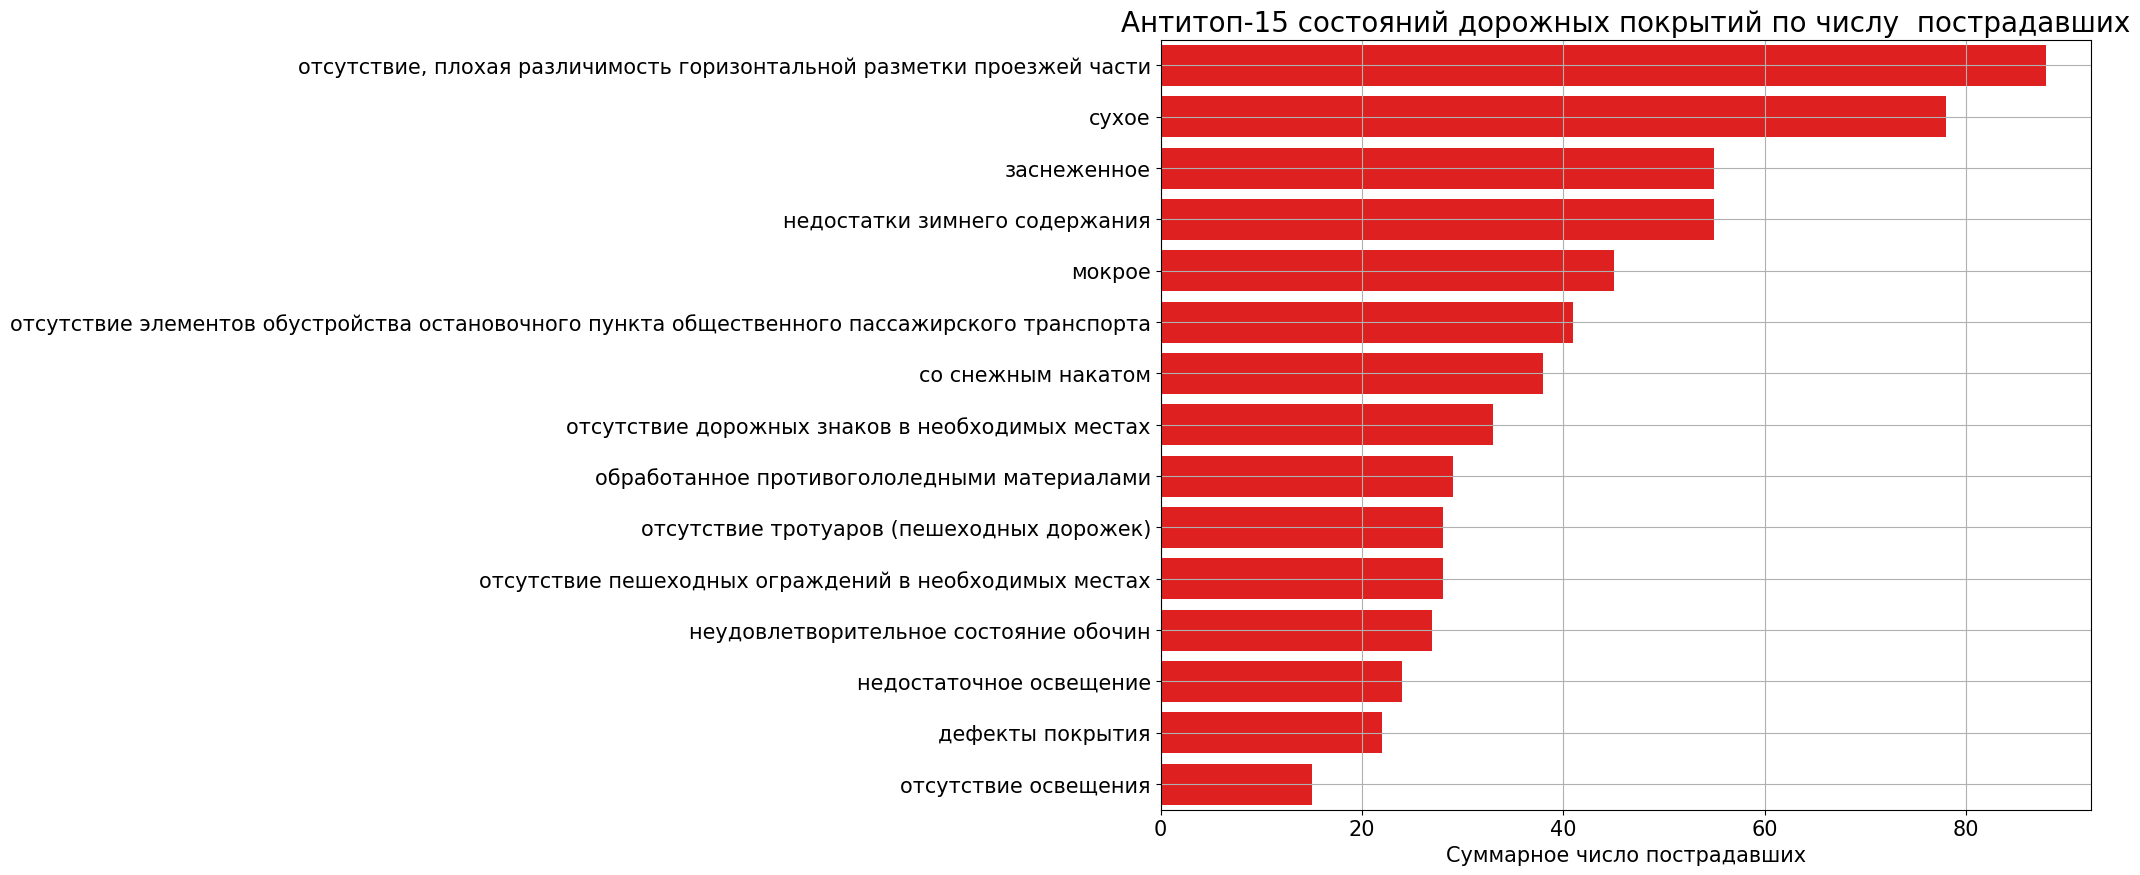

In [53]:

df_injured_sum=df_injured_sum.reset_index().head(15)

# Построение диаграммы
plt.figure(figsize=(12, 10))
ax=sns.barplot(x= 'injured_count', y='road_conditions', data=df_injured_sum, color='red')
plt.title('Антитоп-15 состояний дорожных покрытий по числу  пострадавших', fontsize=20)
plt.xlabel('Суммарное число пострадавших', fontsize=15)
plt.ylabel(None)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()

- Чаще всего на число пострадавших в ДТП влияет отсутствие, плохая различимость горизонтальной разметки проезжей части

### 3. Связь категории аварий с погодными условиями

Выведем количество ДТП сгруппированому по категоии аварий и погодным условиям

In [54]:
df_group_cat_wet = df.groupby(['category', 'weather'])['id'].nunique().sort_values(ascending=False).head(20).reset_index()

df_group_cat_wet


,category,weather,id
0,столкновение,['пасмурно'],2514
1,столкновение,['ясно'],2288
2,наезд на пешехода,['пасмурно'],2268
3,наезд на пешехода,['ясно'],1572
4,съезд с дороги,['ясно'],586
5,опрокидывание,['ясно'],532
6,съезд с дороги,['пасмурно'],431
7,наезд на велосипедиста,['ясно'],397
8,падение пассажира,['пасмурно'],390
9,опрокидывание,['пасмурно'],367


Выведем число случаев ДТП по категория ДТП

In [55]:
category= pd.DataFrame(df['category'].value_counts()).reset_index()
category

,category,count
0,столкновение,8524
1,наезд на пешехода,6831
2,съезд с дороги,1798
3,опрокидывание,1516
4,падение пассажира,1158
5,наезд на препятствие,1019
6,наезд на велосипедиста,910
7,наезд на стоящее тс,497
8,иной вид дтп,207
9,наезд на животное,146


Число ДТП по погодным условиям

In [56]:
weather= pd.DataFrame(df['weather'].value_counts()).reset_index().style.background_gradient(cmap='coolwarm')
weather

,weather,count
0,['пасмурно'],10464
1,['ясно'],9802
2,['снегопад'],981
3,['дождь'],930
4,"['пасмурно', 'снегопад']",153
5,"['пасмурно', 'дождь']",119
6,"['ясно', 'температура выше +30с']",100
7,['метель'],43
8,['туман'],28
9,"['снегопад', 'метель']",19


Построим тепловую карту числа ДТП по категориям ДТП от погодных условий

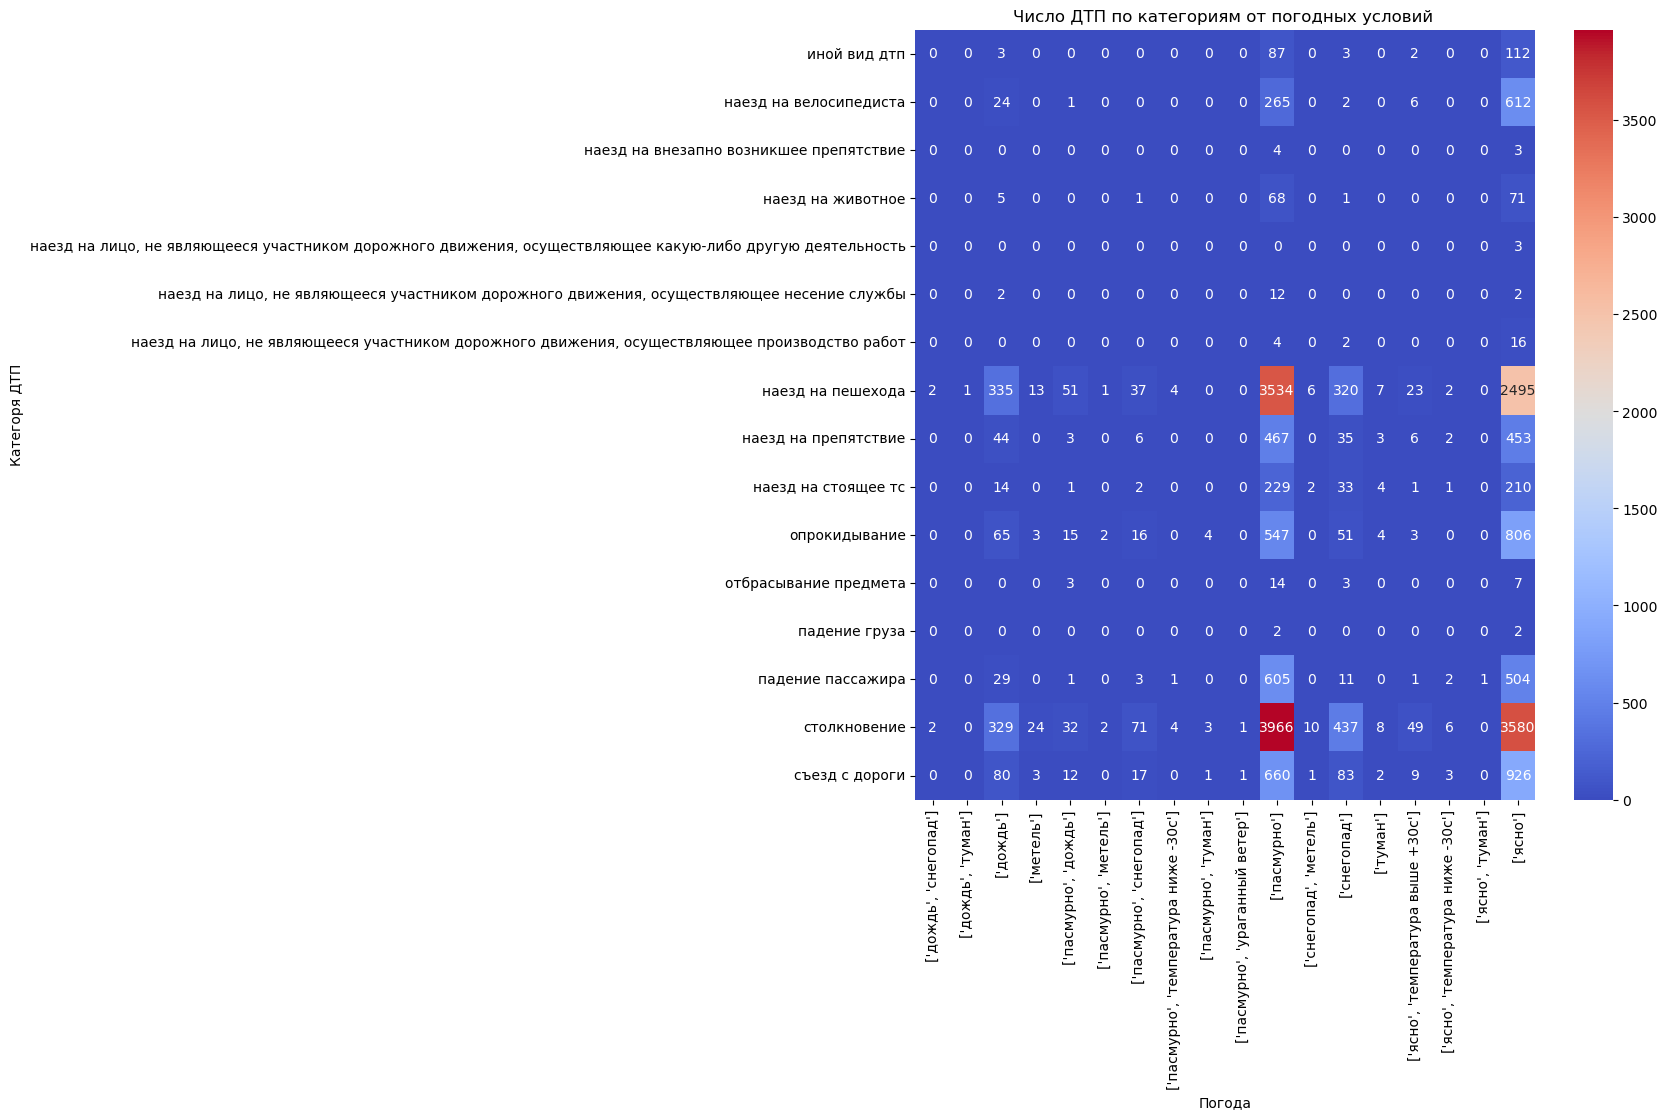

In [57]:
# Создаем таблицу сопряженности
cross_table = pd.crosstab(df['category'], df['weather'])

# Тепловая карта
plt.figure(figsize=(10, 10))
sns.heatmap(
    cross_table, 
    annot=True,   
    cmap='coolwarm', 
    fmt='d',
)
plt.title('Число ДТП по категориям от погодных условий ')
plt.xlabel('Погода')
plt.ylabel('Категоря ДТП')
plt.show()

- Самые частые категории ДТП `столкновение`, `наезд на пешехода` и `съезд с дороги`
- Самые частые погодные условия `пасмурно`, `ясно`, `снегопад`, `дождь`

### 4. Процентная разбивка аварий по видам освещённости с учетом пола участника и сделаем расчёты для мужчин и женщин отдельно.

Посчитаем процент ДТП в зависимости от освещения с участием мужчин от общего числа мужчин

In [58]:
mans_light = round(df[df['gender']=='Мужской'].groupby('light')['gender'].count()/
      ((df['gender']=='Мужской').sum()), 3)*100
mans_light

light
в темное время суток, освещение включено       21.8
в темное время суток, освещение не включено     1.5
в темное время суток, освещение отсутствует     9.8
светлое время суток                            63.8
сумерки                                         3.1
Name: gender, dtype: float64

Посчитаем процент ДТП в зависимости от освещения с участием женщин от общего числа женщин

In [59]:
womans_light = round(df[df['gender']=='Женский'].groupby('light')['gender'].count()/
      ((df['gender']=='Женский').sum()), 3)*100
womans_light

light
в темное время суток, освещение включено       22.4
в темное время суток, освещение не включено     1.3
в темное время суток, освещение отсутствует     9.2
светлое время суток                            64.4
сумерки                                         2.7
Name: gender, dtype: float64

In [60]:
mans_womans_light = pd.DataFrame({'Мужчины': mans_light,
                                  'Женщины': womans_light
    
})
mans_womans_light

,Мужчины,Женщины
light,,
"в темное время суток, освещение включено",21.8,22.4
"в темное время суток, освещение не включено",1.5,1.3
"в темное время суток, освещение отсутствует",9.8,9.2
светлое время суток,63.8,64.4
сумерки,3.1,2.7


In [61]:
df['light'].value_counts()

light
светлое время суток                            14512
в темное время суток, освещение включено        4952
в темное время суток, освещение отсутствует     2209
сумерки                                          666
в темное время суток, освещение не включено      346
Name: count, dtype: int64

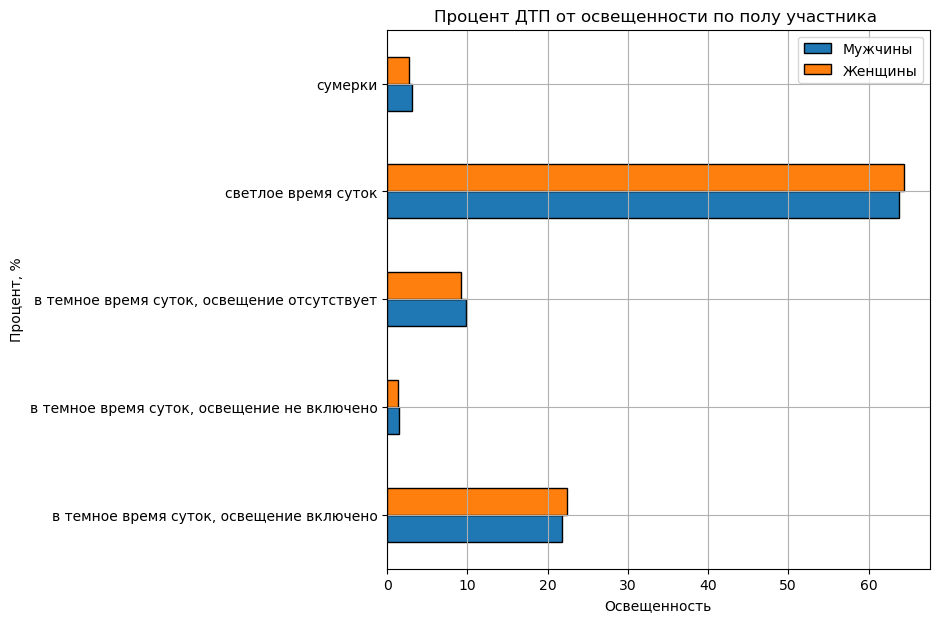

In [62]:
mans_womans_light.plot(kind='barh',
               title='Процент ДТП от освещенности по полу участника ',
               legend=True,
               xlabel='Освещенность',
               ylabel='Процент, %',
               rot=0,
               edgecolor = 'black',
               figsize=(7, 7))
plt.grid()
plt.show()

- Для мужчин и женщин в целом характерны приблизительно равные доли участия в ДТП.
- Участия женщин больше, чем мужчин в светлое время суток (64.4% и 63.8% соответственно) и темное с включенным освещением (22.4% и 21.8% соответственно)
- Участия мужчин больше чем женщин в сумерках (3.1% и 2.7% соответственно), в темное время суток, освещение не включено (1.5% и 1.3% соответственно) и в в темное время суток, освещение отсутствует (9.8% и 9.2% соответственно)
- В затемненных условиях участие в ДТП мужчин больше, а в условиях с освещением больше участие женщин

### 5. Исследование отличия аварий без пострадавших от тех, в которых был один пострадавший или более.

In [63]:
df.head()

,geometry_coordinates,id,tags,light,point_lat,point_long,nearby,region,scheme,address,...,injured_count,parent_region,road_conditions,participants_count,participant_categories,role,gender,violations,health_status,years_of_driving_experience
0,"[47.886008, 57.30447]",1979481,дорожно-транспортные происшествия,светлое время суток,57.304470,47.886008,"['Многоквартирные жилые дома', 'Нерегулируемый...",яранский район,740.0,"г яранск, ул кирова, 25",...,1,кировская область,['сухое'],2,"['все участники', 'пешеходы', 'дети']",водитель,Мужской,[],не пострадал,26
1,"[47.886008, 57.30447]",1979481,дорожно-транспортные происшествия,светлое время суток,57.304470,47.886008,"['Многоквартирные жилые дома', 'Нерегулируемый...",яранский район,740.0,"г яранск, ул кирова, 25",...,1,кировская область,['сухое'],2,"['все участники', 'пешеходы', 'дети']",пешеход,Женский,[],"раненый, находящийся (находившийся) на амбула...",<NA>
2,"[50.737665, 57.822582]",1979482,дорожно-транспортные происшествия,светлое время суток,57.822582,50.737665,['Жилые дома индивидуальной застройки'],богородский район,610.0,"пгт богородское, ул советская, 97",...,1,кировская область,['сухое'],2,['все участники'],водитель,Мужской,['нарушение правил расположения тс на проезжей...,не пострадал,<NA>
3,"[50.737665, 57.822582]",1979482,дорожно-транспортные происшествия,светлое время суток,57.822582,50.737665,['Жилые дома индивидуальной застройки'],богородский район,610.0,"пгт богородское, ул советская, 97",...,1,кировская область,['сухое'],2,['все участники'],пешеход,Мужской,[],"раненый, находящийся (находившийся) на амбула...",<NA>
4,"[47.14992, 58.1711]",1979483,дорожно-транспортные происшествия,светлое время суток,58.171100,47.149920,[],шабалинский район,200.0,"кострома - шарья - киров - пермь р-243, 64 км",...,3,кировская область,['мокрое'],5,['все участники'],пассажир,Женский,[],получил телесные повреждения с показанием к ле...,<NA>


Создадим столбец с бинарными значениями, в котором 0 - ДТП без пострадавших, 1 - с пострадавшими

In [64]:
df['binary'] = np.where(df['health_status'] == 'не пострадал', 0, 1)

In [65]:
df['binary'].value_counts()

binary
1    13331
0     9354
Name: count, dtype: int64

Для того чтобы определить условия, которые влияют на значения в бинарном столбце построим матрицу корреляции других признаков с этим столбцом 

In [66]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df[['light', 'tags', 'region', 'scheme', 'parent_region',
                         'road_conditions', 'participants_count', 'role', 'gender',
                         'violations', 'years_of_driving_experience', 'binary']].phik_matrix()
print('Корреляционная матрица с коэффициентом phi_k для переменной binary')
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'binary'][['binary']].sort_values(by='binary', ascending=False)

data_heatmap.style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['participants_count', 'years_of_driving_experience', 'binary']


C:\Users\urize\AppData\Roaming\Python\Python312\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable violations is large: 1435. Are you sure this is not an interval variable? Analysis for pairs of variables including violations can be slow.
  warnings.warn(
C:\Users\urize\AppData\Roaming\Python\Python312\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable parent_region for analysis 1. Dropping this column
  warnings.warn(
C:\Users\urize\AppData\Roaming\Python\Python312\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable tags for analysis 1. Dropping this column
  warnings.warn(


Корреляционная матрица с коэффициентом phi_k для переменной binary


,binary
violations,0.715189
role,0.545732
gender,0.509145
region,0.267298
years_of_driving_experience,0.099762
scheme,0.052899
light,0.019107
road_conditions,0.000000
participants_count,0.000000


- violations наиболее высокая корреляция 0.72 - какие правила дорожного движения были нарушены
- role - 0.55 роль участника ДТП
- gender - 0.51 пол участника ДТП

In [67]:
df.groupby('violations')['binary'].sum().sort_values(ascending=False).head()

violations
[]                                                                                                                                                                          6623
['иные нарушения']                                                                                                                                                           395
['переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода']     352
['несоответствие скорости конкретным условиям движения']                                                                                                                     333
['переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)']                                                                          308
Name: binary, dtype: int32

Сильная корреляция со столбцом violations, по видимому обусловлена тем, что для ДТП с пострадавшими конкретное правило, которое было нарушено не указано

**Для оценки различия ДТП с пострадавшими и без будем использовать показатель доли пострадавших в зависимости от признака**

In [68]:
df.groupby('role')['binary'].agg(['mean', 'count']).sort_values(by = 'mean', ascending=False).style.background_gradient(cmap='coolwarm')

,mean,count
role,,
велосипедист,0.995495,222
пешеход,0.993390,4236
"пешеход, перед дтп находившийся в (на) тс в качестве водителя или пешеход, перед дтп находившийся в (на) тс в качестве пассажира",0.984375,64
пассажир,0.944458,3961
водитель,0.301036,13025


In [69]:
df.groupby('gender')['binary'].agg(['mean', 'count']).sort_values(by = 'mean', ascending=False).style.background_gradient(cmap='coolwarm')

,mean,count
gender,,
Женский,0.824870,6538
Мужской,0.461875,14413


In [70]:
df.groupby('region')['binary'].agg(['mean', 'count']).sort_values(by = 'mean', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,mean,count
region,,
вятско-полянский район,1.000000,393
кирово-чепецки район,0.874380,1210
шабалинский район,0.742515,167
фаленский район,0.704545,88
немский район,0.704082,98
тужинский район,0.700000,70
нолинский район,0.687500,272
советский район,0.685015,327
санчурский район,0.675676,74


Отличие ДТП с пострадавшими коррелирует с такими признаками как нарушенное правило, роль, пол и регион
Наибольшая доля пострадавших в ДТП характерна для
- участников: велосипедист (0.99), пешеход (0.99), пассажир (0.94), для водителей не характерна (0.3)
- женщин (0.82) в существенно большей мере , чем для мужчин (0.46)
- регионов: вятско-полянский район (1.0), киропо-чепецкий район (0.87), шабалинский район (0.74)
- топе правил нарушенных при ДТП: 'переход через проезжую часть вне пешеходного перехода', 'несоответствие скорости конкретным условиям движения' 

### Общий вывод

- Наиболее типичное число участников ДТП 2.
- 59,3 % случаев ДТП происходит с 2 участниками, это вполне логично, учитывая, что как правило в ДТП учавствуют 2 стороны: водитель-водитель или водитель-пешеход, 20,2 % с 3 участниками, по-видимому с участием еще и пассажира, 10,6 с одним в случаях ДТП с одним ТС, например при сьезде с дороги.
- В 79,6 % случаев ДТП имеется один пострадавший, двое в 13,5 % происшествий, трое в 4,2 %
- Чаще всего на число пострадавших в ДТП влияет отсутствие, плохая различимость горизонтальной разметки проезжей части
- Самые частые категории ДТП `столкновение`, `наезд на пешехода` и `съезд с дороги`
- Самые опасные погодные условия `пасмурно`, `ясно`, `снегопад`, `дождь`
- Для мужчин и женщин в целом характерны приблизительно равные доли участия в ДТП.
- Участия женщин больше, чем мужчин в светлое время суток (64.4% и 63.8% соответственно) и темное с включенным освещением (22.4% и 21.8% соответственно)
- Участия мужчин больше чем женщин в сумерках (3.1% и 2.7% соответственно), в темное время суток, освещение не включено (1.5% и 1.3% соответственно) и в в темное время суток, освещение отсутствует (9.8% и 9.2% соответственно)
- В затемненных условиях участие в ДТП мужчин больше, а в условиях с освещением больше участие женщин

Отличие ДТП с пострадавшими коррелирует с такими признаками как нарушенное правило, роль, пол и регион
Наибольшая доля пострадавших в ДТП характерна для
- участников: велосипедист (0.99), пешеход (0.99), пассажир (0.94), для водителей не характерна (0.3)
- водителей женщин (0.82) в существенно большей мере , чем для мужчин (0.46)
- регионов: Вятско-полянский район (1.0), Киропо-чепецкий район (0.87), Шабалинский район (0.74)
- топе правил нарушенных при ДТП: 'переход через проезжую часть вне пешеходного перехода', 'несоответствие скорости конкретным условиям движения' 

**Рекомендации**
- Повысить уровень знания ПДД и безопасности для женщин
- Уделить внимание таким факторам как велосипедные дорожки, дорожная разметка и освещение дорог
- Особенно высокая аварийность с пострадавшими по Вятско-полянскому, Киропо-чепецкому и Шабалинскому районам